# Binary Image Classification: Ants vs Bees with Transfer Learning

This project implements binary image classification to distinguish between ants and bees using different deep learning approaches and transfer learning strategies.

## Project Overview

This project demonstrates **binary image classification** using the Hymenoptera dataset, comparing different training strategies to achieve optimal performance on a small dataset.

### **Dataset**: Hymenoptera Dataset
- **Classes**: 2 (Ants and Bees)
- **Training Images**: ~120 images per class
- **Validation Images**: ~75 images per class
- **Image Size**: 224×224 pixels (after preprocessing)
- **Challenge**: Small dataset size requires effective transfer learning strategies

### **Model Architecture**: ResNet-18
- **Base Model**: ResNet-18 pretrained on ImageNet
- **Modifications**: Final layer adapted for 2-class classification
- **Input**: RGB images (224×224×3)
- **Output**: Binary classification (Ant vs Bee)

### **Training Strategies Compared**:

#### 1. **Training from Scratch**
- Initialize ResNet-18 with random weights
- Train all parameters on the small dataset
- Baseline approach to compare transfer learning benefits

#### 2. **Transfer Learning (Frozen Features)**
- Use pretrained ResNet-18 ImageNet weights
- Freeze all convolutional layers
- Only train the final classification layer
- Fast training, suitable for very small datasets

#### 3. **Fine-tuning (All Parameters)**
- Start with pretrained ResNet-18 weights
- Train all network parameters with lower learning rate
- Best performance but requires careful hyperparameter tuning

### **Key Features**:
- **Data Augmentation**: Random crops, horizontal flips, normalization
- **Transfer Learning**: Leveraging ImageNet pretrained models
- **Performance Comparison**: Detailed analysis of different approaches
- **Visualization**: Training curves, sample predictions, model performance
- **Best Practices**: Learning rate scheduling, early stopping, model checkpointing

### **Technical Implementation**:
- **Framework**: PyTorch
- **Optimizer**: SGD with momentum
- **Loss Function**: Cross-entropy loss
- **Metrics**: Accuracy, training/validation loss curves
- **Hardware**: GPU acceleration support

### **Expected Outcomes**:
- **Performance Ranking**: Fine-tuning > Transfer Learning > Training from Scratch
- **Training Efficiency**: Transfer learning approaches converge faster
- **Generalization**: Pretrained models show better generalization on small datasets

---

[0.5198643207550049, 0.4702523648738861, 0.3441820740699768] [0.27000948786735535, 0.25354665517807007, 0.2807126045227051]
Classes: ['ants', 'bees']
Train size: 244,  Val size: 153


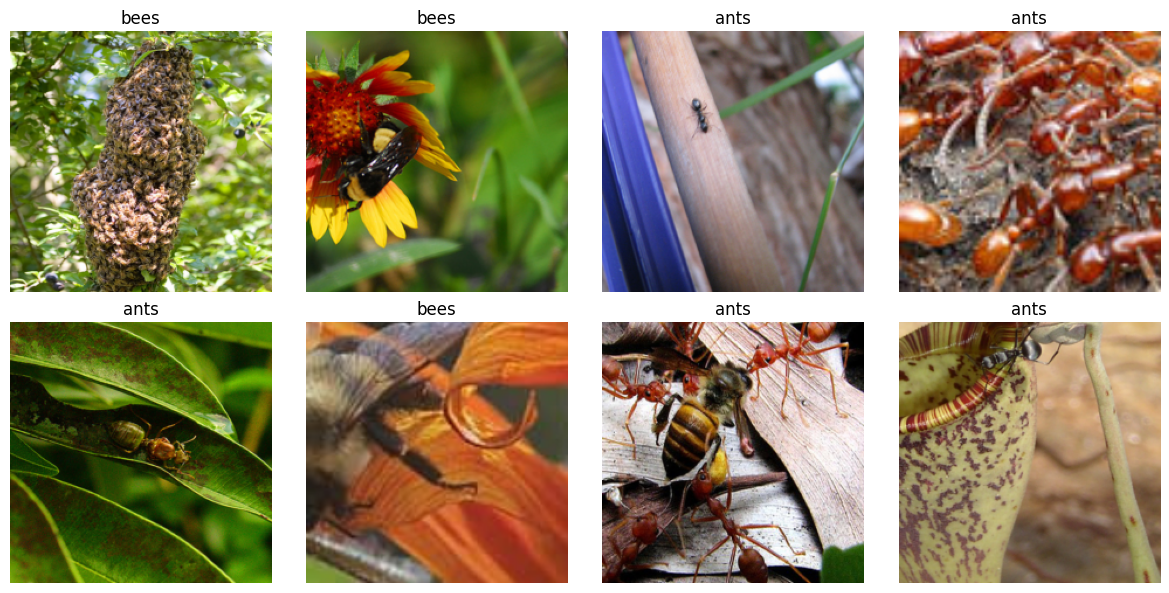

In [ ]:
# Dataset Setup and Data Loading
from pathlib import Path

DATA_DIR = Path("hymenoptera_data")

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch

# Basic transformation for dataset statistics calculation
plain_tfms = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(DATA_DIR/"train", transform=plain_tfms)
loader  = DataLoader(dataset, batch_size=64, num_workers=4)

# Calculate dataset normalization parameters
mean = torch.zeros(3)
var = torch.zeros(3)
N = 0

for imgs, _ in loader:
    B, C, H, W = imgs.shape
    imgs = imgs.view(B, C, -1)  # [B, 3, H*W]
    N += B*H*W
    mean += imgs.sum(dim=(0, 2))
    var  += (imgs ** 2).sum(dim=(0, 2))

mean /= N
std  = (var / N - mean**2).sqrt()

mean = mean.tolist()
std  = std.tolist()

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

image_datasets = {
    "train": datasets.ImageFolder(DATA_DIR / "train", transform=train_tfms),
    "val"  : datasets.ImageFolder(DATA_DIR / "val",   transform=val_tfms),
}

dataloaders = {
    phase: DataLoader(
        image_datasets[phase],
        batch_size=32,
        shuffle=(phase == "train"),
        num_workers=4,
        pin_memory=True,
    )
    for phase in ["train", "val"]
}

class_names = image_datasets["train"].classes
print(f"Classes: {class_names}")  # ['ants', 'bees']
print(f"Train size: {len(image_datasets['train'])}, Val size: {len(image_datasets['val'])}")

# Data Visualization
import matplotlib.pyplot as plt
import torch

def imshow(inp, title=None):
    """Display image tensor after denormalization"""
    inp = inp.permute(1, 2, 0).numpy()
    inp = std * inp + mean  # Denormalize
    inp = inp.clip(0, 1)
    plt.imshow(inp)
    if title: plt.title(title)
    plt.axis("off")

inputs, labels = next(iter(dataloaders["train"]))
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(inputs[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()

In [ ]:
import time, copy, torch, torch.nn as nn, torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the pre-trained ResNet-18 model
model = models.resnet18(weights="IMAGENET1K_V1")
model = model.to(device)

# Get the number of features of the output layer
num_ftrs = model.fc.in_features
print(f"ResNet-18 fc in_features = {num_ftrs}")

# Replace the layer with a 2-class classifier
model.fc = nn.Linear(num_ftrs, 2)      # 二分类
model.fc = model.fc.to(device)

# Train the model
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),
                      lr=0.001,
                      momentum=0.9,
                      weight_decay=1e-4)

num_epochs = 15
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                 T_max=num_epochs)

def train_model(model, dataloaders, criterion, optimizer, scheduler,
                num_epochs=10, device="cuda"):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        since_epoch = time.time()
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # stats
                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()        # Cosine decay

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc  = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase:5s}  | loss {epoch_loss:.4f}  acc {epoch_acc:.4f}")

            # keep track of the best model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch time: {(time.time()-since_epoch):.1f}s")

    print(f"\nBest val acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# implement the training process
best_model = train_model(model, dataloaders, criterion,
                         optimizer, scheduler,
                         num_epochs=num_epochs,
                         device=device)

print("Training finished.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\INK/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


Using device: cuda


100%|██████████| 44.7M/44.7M [00:03<00:00, 11.8MB/s]


ResNet-18 fc in_features = 512

Epoch 1/15
train  | loss 0.7113  acc 0.5615
val    | loss 0.5083  acc 0.7843
Epoch time: 7.4s

Epoch 2/15
train  | loss 0.4753  acc 0.8156
val    | loss 0.3140  acc 0.9150
Epoch time: 6.9s

Epoch 3/15
train  | loss 0.3240  acc 0.8770
val    | loss 0.2360  acc 0.9281
Epoch time: 6.9s

Epoch 4/15
train  | loss 0.2638  acc 0.9057
val    | loss 0.2138  acc 0.9281
Epoch time: 7.0s

Epoch 5/15
train  | loss 0.2058  acc 0.9344
val    | loss 0.2077  acc 0.9281
Epoch time: 7.0s

Epoch 6/15
train  | loss 0.2009  acc 0.9385
val    | loss 0.1765  acc 0.9412
Epoch time: 7.0s

Epoch 7/15
train  | loss 0.1507  acc 0.9467
val    | loss 0.1762  acc 0.9477
Epoch time: 7.0s

Epoch 8/15
train  | loss 0.1395  acc 0.9426
val    | loss 0.1724  acc 0.9477
Epoch time: 7.2s

Epoch 9/15
train  | loss 0.1458  acc 0.9508
val    | loss 0.1731  acc 0.9412
Epoch time: 7.0s

Epoch 10/15
train  | loss 0.1445  acc 0.9631
val    | loss 0.1736  acc 0.9477
Epoch time: 7.1s

Epoch 11/15
train

[finetune] Epoch 1/15 train_acc=0.533 val_acc=0.850
[finetune] Epoch 2/15 train_acc=0.807 val_acc=0.935
[finetune] Epoch 3/15 train_acc=0.873 val_acc=0.941
[finetune] Epoch 4/15 train_acc=0.934 val_acc=0.954
[finetune] Epoch 5/15 train_acc=0.934 val_acc=0.961
[finetune] Epoch 6/15 train_acc=0.930 val_acc=0.948
[finetune] Epoch 7/15 train_acc=0.971 val_acc=0.954
[finetune] Epoch 8/15 train_acc=0.930 val_acc=0.935
[finetune] Epoch 9/15 train_acc=0.922 val_acc=0.967
[finetune] Epoch 10/15 train_acc=0.947 val_acc=0.961
[finetune] Epoch 11/15 train_acc=0.980 val_acc=0.961
[finetune] Epoch 12/15 train_acc=0.971 val_acc=0.961
[finetune] Epoch 13/15 train_acc=0.967 val_acc=0.961
[finetune] Epoch 14/15 train_acc=0.967 val_acc=0.961
[finetune] Epoch 15/15 train_acc=0.967 val_acc=0.961
>>> finetune best val acc = 0.9673
[freeze] Epoch 1/15 train_acc=0.520 val_acc=0.582
[freeze] Epoch 2/15 train_acc=0.676 val_acc=0.882
[freeze] Epoch 3/15 train_acc=0.820 val_acc=0.948
[freeze] Epoch 4/15 train_acc

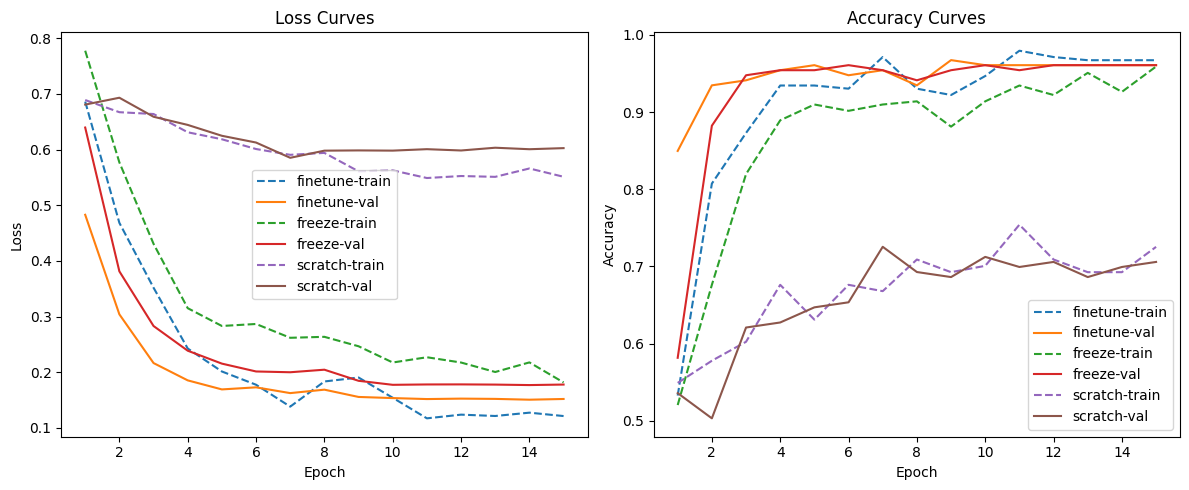

In [ ]:
import copy, time, torch, torch.nn as nn, torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

NUM_EPOCHS   = 15
BATCH_SIZE   = 32
LR           = 1e-3
MOMENTUM     = 0.9
WEIGHT_DECAY = 1e-4
T_MAX        = NUM_EPOCHS

# Experiment with different training strategies: finetune all parameters, freeze feature extractor, train from scratch
def get_model(exp_name):
    """根据实验要求返回模型与训练策略."""
    if exp_name == "finetune":
        model = models.resnet18(weights="IMAGENET1K_V1")
        for p in model.parameters():  # finetune all parameters
            p.requires_grad = True
    elif exp_name == "freeze":
        model = models.resnet18(weights="IMAGENET1K_V1")
        for p in model.parameters():  # freeze feature extractor
            p.requires_grad = False
    elif exp_name == "scratch":
        model = models.resnet18(weights=None)  # random init
    else:
        raise ValueError(exp_name)

    # replace the last layer
    num_ftrs   = model.fc.in_features
    model.fc   = nn.Linear(num_ftrs, 2)
    model      = model.to(device)

    # only train the required parameters
    optim_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer    = optim.SGD(optim_params, lr=LR, momentum=MOMENTUM,
                             weight_decay=WEIGHT_DECAY)
    scheduler    = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)
    return model, optimizer, scheduler

def run_training(exp_name):
    model, optimizer, scheduler = get_model(exp_name)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "val_loss": [],
               "train_acc":  [], "val_acc":  []}

    best_wts, best_acc = copy.deepcopy(model.state_dict()), 0.0

    for epoch in range(NUM_EPOCHS):
        for phase in ["train", "val"]:
            if phase == "train": model.train()
            else:                model.eval()

            running_loss, running_corrects = 0.0, 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss     += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc  = running_corrects.double() / len(dataloaders[phase].dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            if phase == "val" and epoch_acc > best_acc:
                best_acc  = epoch_acc
                best_wts  = copy.deepcopy(model.state_dict())

        print(f"[{exp_name}] Epoch {epoch+1}/{NUM_EPOCHS} "
              f"train_acc={history['train_acc'][-1]:.3f} "
              f"val_acc={history['val_acc'][-1]:.3f}")
        
    model.load_state_dict(best_wts)
    return history, best_acc.item()

# Compute the training curves for each strategy
all_histories, all_acc = {}, {}
for exp in ["finetune", "freeze", "scratch"]:
    hist, acc = run_training(exp)
    all_histories[exp] = hist
    all_acc[exp]       = acc
    print(f">>> {exp} best val acc = {acc:.4f}")

epochs = range(1, NUM_EPOCHS+1)
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
for k in all_histories:
    plt.plot(epochs, all_histories[k]['train_loss'], ls="--", label=f"{k}-train")
    plt.plot(epochs, all_histories[k]['val_loss'],   ls="-",  label=f"{k}-val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend()

# Accuracy
plt.subplot(1,2,2)
for k in all_histories:
    plt.plot(epochs, all_histories[k]['train_acc'], ls="--", label=f"{k}-train")
    plt.plot(epochs, all_histories[k]['val_acc'],   ls="-",  label=f"{k}-val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves"); plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png", dpi=150)
print("Plots saved to training_curves.png")


Finetuning all the parameters performs the best.